In [8]:
%load_ext autoreload
%autoreload 2

In [1]:
import jax
import jax.numpy as jnp

import numpy as np

import openmm, openmm.app
from openmm import unit
kB = unit.MOLAR_GAS_CONSTANT_R.value_in_unit(unit.kilojoule_per_mole/unit.kelvin)

import mdtraj as md
# import nglview as nv

from jax_dataclasses import pytree_dataclass

import flox

In [2]:
from watermodel import *

+++ WARNING: nglview not available +++


In [4]:
temp = 270
ice_type = 'Ih'
n_waters = 16

# path = ''
path = '/group/ag_cmb/scratch/minvernizzi/so3-flow/ice_MDdata/'
info = f'ice{ice_type}_T{temp}_N{n_waters}'
model = WaterModel.load_from_json(f'{path}model-{info}.json')
data = np.load(f'{path}MDtraj-{info}.npz')
pos = data['pos']
box = data['box']
ene = data['ene']

if model.is_box_orthorombic:
    box_edges = np.diagonal(box.squeeze())
    pos = ((pos/box_edges) % 1) * box_edges #force pbc
else:
    print('WARNING: you are working with a non-orthorombic box')

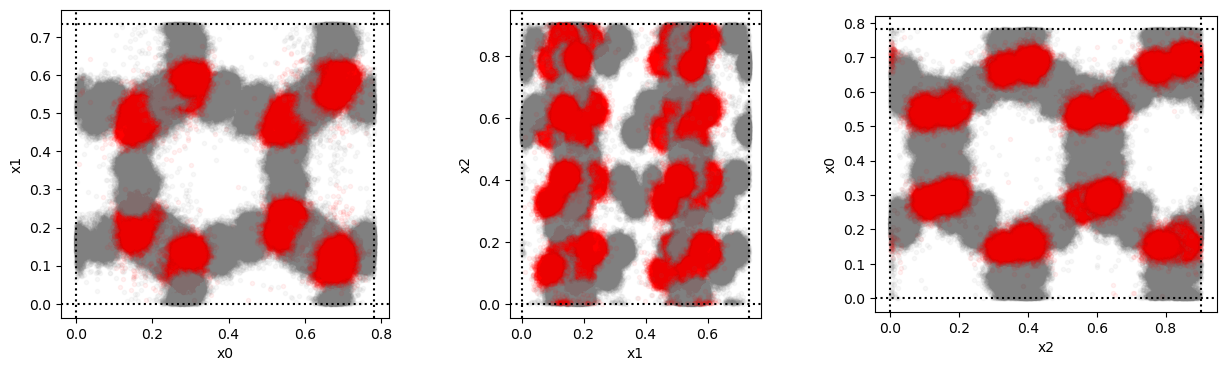

In [5]:
# temp = 270
plot_2Dview(pos[::10], box[::10])

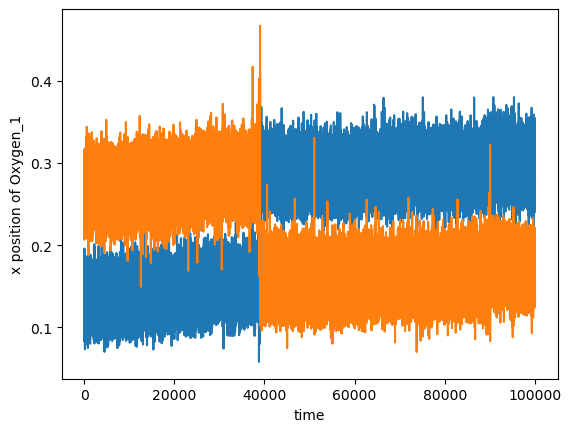

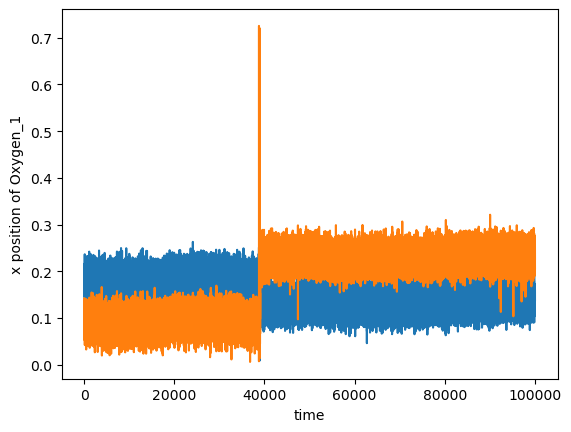

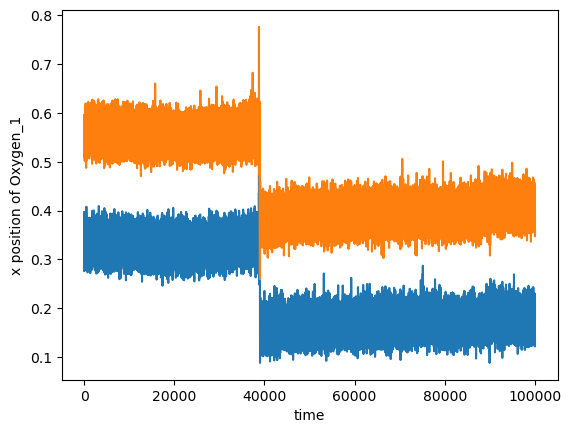

In [9]:
# %matplotlib inline

plt.figure()
for i in range(3):
    plt.plot(pos[:,0,i])
    plt.plot(pos[:,model.n_sites*4,i])
    plt.xlabel('time')
    plt.ylabel('x position of Oxygen_1')
    plt.show()

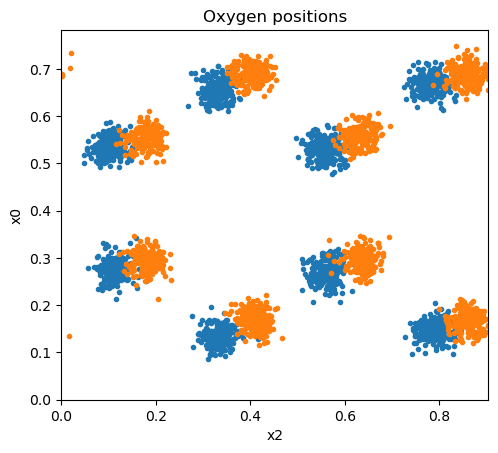

In [20]:
i, ii = 2, 0
plt.figure()
plt.title('Oxygen positions')
# plt.plot(pos[:100,::4,i].reshape(-1), pos[:100,::4,ii].reshape(-1), '.')
# plt.plot(pos[-100:,::4,i].reshape(-1), pos[-100:,::4,ii].reshape(-1), '.')
plt.plot(pos[:100,::4,i].reshape(-1), pos[:100,::4,ii].reshape(-1), '.')
plt.plot(pos[-100:,::4,i].reshape(-1), pos[-100:,::4,ii].reshape(-1), '.')
plt.xlim(0,box[:, i, i].mean())
plt.ylim(0,box[:, ii, ii].mean())
plt.xlabel(f'x{i}')
plt.ylabel(f'x{ii}')
plt.gca().set_aspect(1)
plt.show()

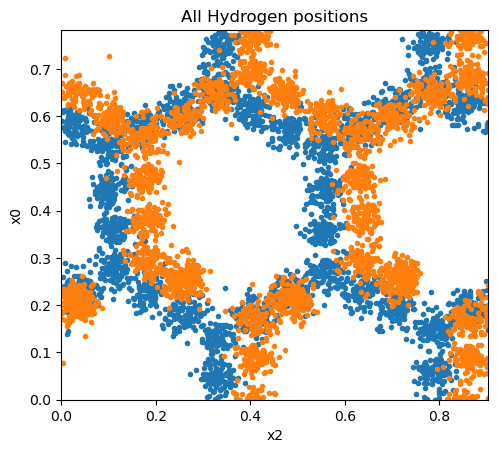

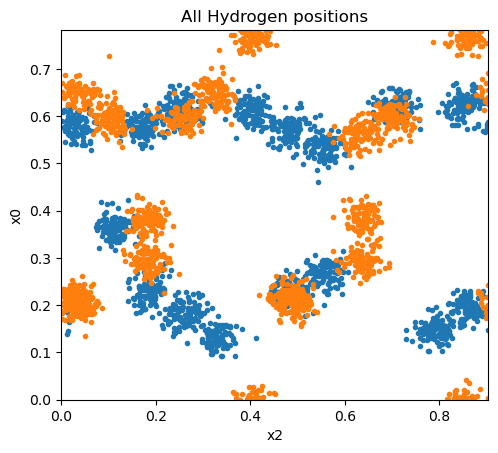

In [15]:
i, ii = 2, 0
plt.figure()
plt.title('All Hydrogen positions')
line, *_ = plt.plot(pos[:100,1::4,i].reshape(-1), pos[:100,1::4,ii].reshape(-1), '.')
plt.plot(pos[:100,2::4,i].reshape(-1), pos[:100,2::4,ii].reshape(-1), '.', c=line.get_color())
line, *_ = plt.plot(pos[-100:,1::4,i].reshape(-1), pos[-100:,1::4,ii].reshape(-1), '.')
plt.plot(pos[-100:,2::4,i].reshape(-1), pos[-100:,2::4,ii].reshape(-1), '.', c=line.get_color())
plt.xlim(0,box[:, i, i].mean())
plt.ylim(0,box[:, ii, ii].mean())
plt.xlabel(f'x{i}')
plt.ylabel(f'x{ii}')
plt.gca().set_aspect(1)
plt.show()

i, ii = 2, 0
plt.figure()
plt.title('All Hydrogen positions')
line, *_ = plt.plot(pos[:100,1::4,i].reshape(-1), pos[:100,1::4,ii].reshape(-1), '.')
# plt.plot(pos[:100,2::4,i].reshape(-1), pos[:100,2::4,ii].reshape(-1), '.', c=line.get_color())
line, *_ = plt.plot(pos[-100:,1::4,i].reshape(-1), pos[-100:,1::4,ii].reshape(-1), '.')
# plt.plot(pos[-100:,2::4,i].reshape(-1), pos[-100:,2::4,ii].reshape(-1), '.', c=line.get_color())
plt.xlim(0,box[:, i, i].mean())
plt.ylim(0,box[:, ii, ii].mean())
plt.xlabel(f'x{i}')
plt.ylabel(f'x{ii}')
plt.gca().set_aspect(1)
plt.show()

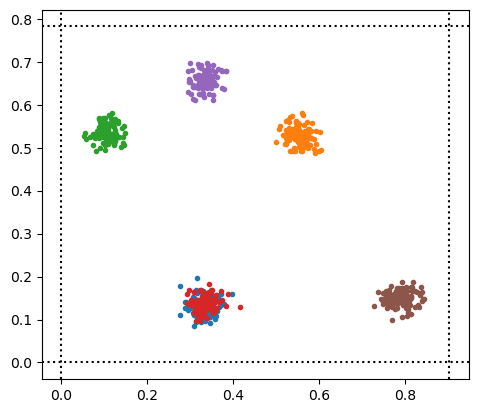

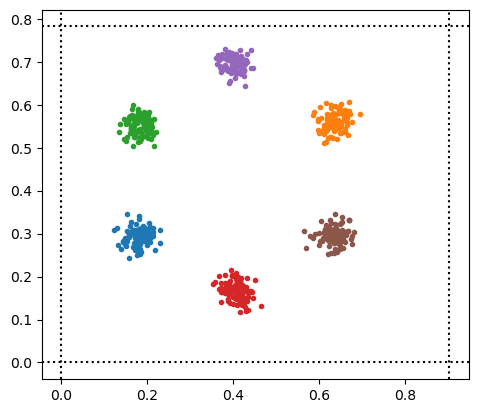

In [32]:
skip = 2
i, ii = 2, 0
plt.figure()
plt.plot(pos[:100,::4*(1+skip),i], pos[:100,::4*(1+skip),ii], '.')
plt.axvline(0, c='k', ls=':')
plt.axhline(0, c='k', ls=':')
plt.axvline(box[:, i, i].mean(), c='k', ls=':')
plt.axhline(box[:,ii,ii].mean(), c='k', ls=':')
plt.gca().set_aspect(1)
plt.show()
plt.figure()
plt.plot(pos[-100:,::4*(1+skip),i], pos[-100:,::4*(1+skip),ii], '.')
plt.axvline(0, c='k', ls=':')
plt.axhline(0, c='k', ls=':')
plt.axvline(box[:, i, i].mean(), c='k', ls=':')
plt.axhline(box[:,ii,ii].mean(), c='k', ls=':')
plt.gca().set_aspect(1)
plt.show()

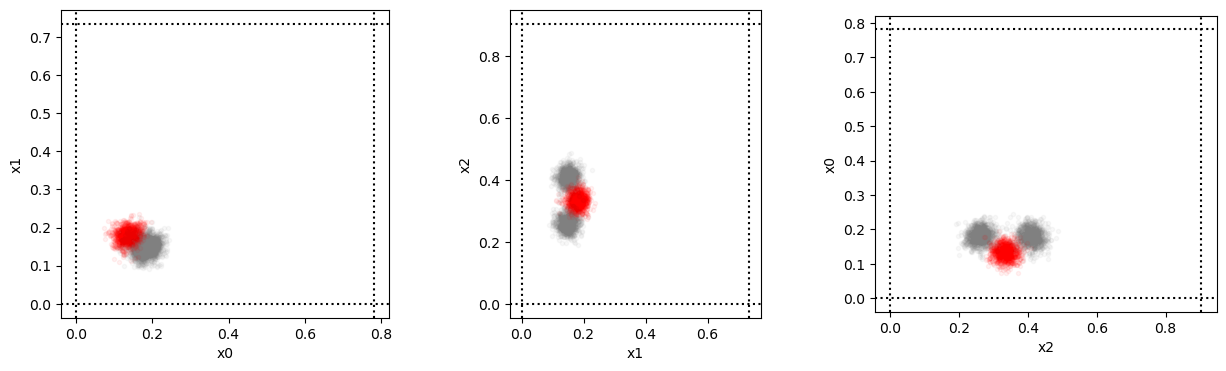

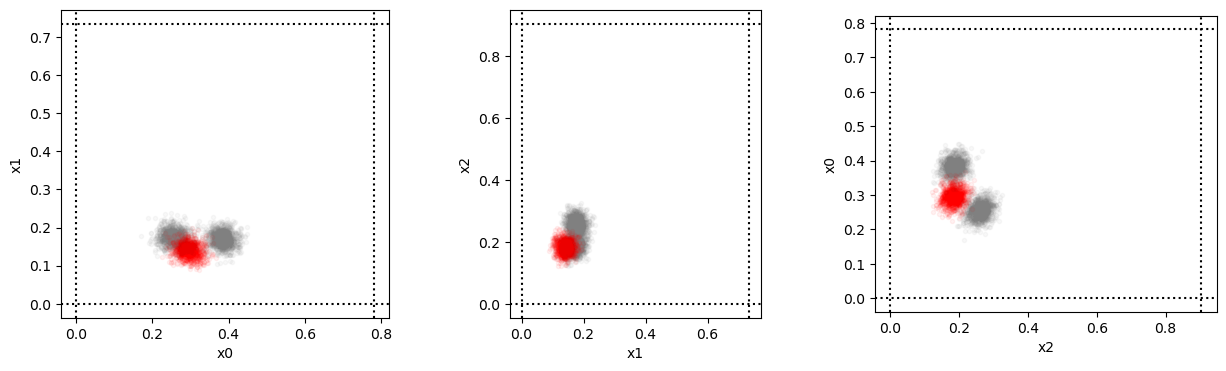

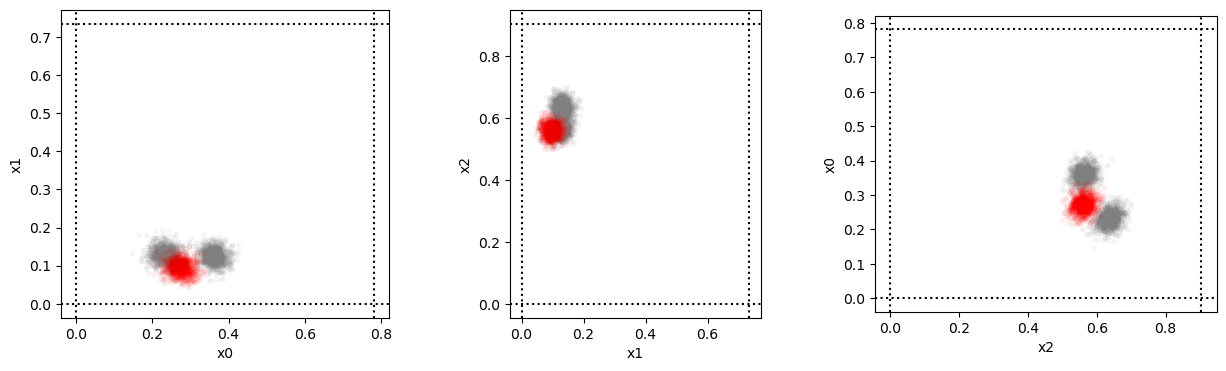

In [24]:
i, j = 0, 4
plot_2Dview(pos[:1000,4*i:4*i+4], box)
plot_2Dview(pos[-1000:,4*i:4*i+4], box)

# plot_2Dview(pos[:1000,4*j:4*j+4], box)
# plot_2Dview(pos[-1000:,4*j:4*j+4], box)

shift = (pos[-100:,i] - pos[:100,4*j]).mean(axis=0)
shifted_pos = (((pos-shift)/box_edges) % 1)*box_edges
plot_2Dview(shifted_pos[-1000:,4*i:4*i+4], box)

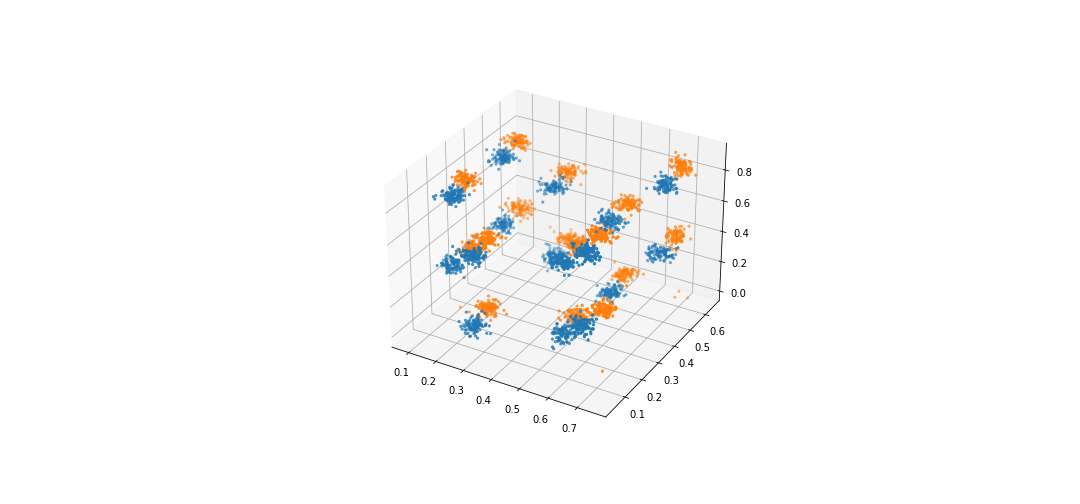

In [61]:
%matplotlib widget

ax = plt.figure(figsize=(15,7)).add_subplot(projection='3d')
def add_scatter(data, ax=ax):
    ax.scatter(data[:,0], data[:,1],data[:,2], marker='.')
add_scatter(pos[:100,::4].reshape(-1,3))

shift = (pos[-100:,0] - pos[:100,4*4]).mean(axis=0)
shifted_pos = (((pos-shift)/box_edges) % 1)*box_edges

# shift = (shifted_pos[-100:,0] - pos[:100,1]).mean(axis=0)
# shifted_pos = (((shifted_pos-shift)/box_edges) % 1)*box_edges

# add_scatter(shifted_pos[-100:,::4].reshape(-1,3))
add_scatter(pos[-100:,::4].reshape(-1,3))


plt.show()

In [106]:
# set PRNG seed
seed = 42

# set PRNG key chain
chain = flox.util.key_chain(seed)

In [125]:
pos = model.positions
state = simulation.context.getState()
box = state.getPeriodicBoxVectors(asNumpy=True).value_in_unit(unit.nanometer)

In [126]:
context = simulation.context
context.reinitialize(preserveState=True)

In [119]:
import matplotlib.pyplot as plt

top = water_mdtraj_topology(1, 4)
pos_ = pos + 0.
pos_[3] += .04
nv.show_mdtraj(md.Trajectory(pos_[0:4], top))

NGLWidget()

In [127]:
# data = np.load("foo.npz")
p_ = data["positions"]
b_ = data["box"]
p_.shape, b_.shape

torus = geom.Torus(b_)

p_ = p_.reshape(p_.shape[0], -1, 4, 3)

def normalize(p, t):
    print(p.shape)
    dR = jax.vmap(t.tangent, in_axes=(None, 0))(
        p[0], p[1:] - p[0, :][None]
    )
    print(dR.shape, p.shape)
    out = jnp.concatenate([
        p[0, :][None],
        p[0, :][None] + dR
    ], axis=-2)
        
    print(out.shape)
    return out

print(p_.shape)
p_ = jax.vmap(jax.vmap(normalize, in_axes=(0, None)))(p_, torus)
p_.shape

(50000, 16, 4, 3)
(4, 3)
(3, 3) (4, 3)
(4, 3)


(50000, 16, 4, 3)

In [131]:
p_.shape, b_.shape

((50000, 16, 4, 3), (50000, 3))

In [132]:
to_rigid(p_[0], b_[0])

TypeError: to_rigid() takes 1 positional argument but 2 were given

In [138]:
from flox.flow import rigid

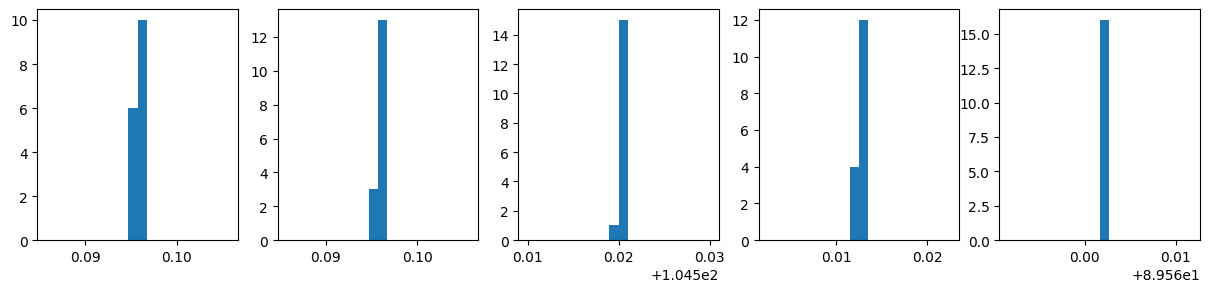

In [142]:
from functools import partial
from flox import geom 
torus = geom.Torus(jnp.diag(box))

def to_rigid(pos, manifold):
    p_O, p_H1, p_H2, p_M = pos
    q, p, d_OH1, d_OH2, a_HOH = rigid.from_euclidean(pos[:3])
    ldj = rigid.from_euclidean_log_jacobian(pos)
    r_OM = manifold.tangent(
        p_O, p_M - p_O
    )
    r_OM = geom.qrot3d(geom.qconj(q), r_OM)
    d_OM = geom.norm(r_OM)
    a_OM = jnp.arccos(geom.inner(r_OM, jnp.array([0., 0., 1.])))
    return q, p, d_OH1, d_OH2, a_HOH, d_OM, a_OM
    
    
q, p, d_OH1, d_OH2, a_HOH, d_OM, a_OM = jax.vmap(partial(to_rigid, manifold=torus))(pos.reshape(-1, 4, 3))
a_HOH = a_HOH * 180 / jnp.pi
a_OM = a_OM * 180 / jnp.pi

plt.figure(figsize=(5 * 3, 3))
for i, x in enumerate([d_OH1, d_OH2, a_HOH, d_OM, a_OM], start=1):
    plt.subplot(1, 5, i)
    plt.hist(x, range=(x.min() - 0.01, x.max() + 0.01), bins=20)

In [161]:

from flox import geom
from functools import partial

q, p, d_OH1, d_OH2, a_HOH, d_OM, a_OM = jax.vmap(jax.vmap(partial(to_rigid), in_axes=(0, None)))(
    p_.reshape(p_.shape[0], -1, 4, 3),
    geom.Torus(b_),
)
# a_HOH = a_HOH * 180 / jnp.pi
# a_OM = a_OM * 180 / jnp.pi

# plt.figure(figsize=(5 * 3, 3))
# for i, x in enumerate([d_OH1.reshape(-1), d_OH2.reshape(-1), a_HOH.reshape(-1), d_OM.reshape(-1), a_OM.reshape(-1)], start=1):
#     plt.subplot(1, 5, i)
#     plt.hist(x, range=(x.min() - 0.01, x.max() + 0.01), bins=20)

In [162]:
q.shape, p.shape

((50000, 16, 4), (50000, 16, 3))

In [158]:
i = 8

q, r, b1, b2, a = rigid.from_euclidean(
    pos_[0 + i * 4:3 + i * 4]
)
q = flox.geom.qconj(q)

r_OH = pos[1 + i*4] - pos[0 + i*4]
r_OH2 = pos[2 + i*4] - pos[0 + i*4]
r_OM = pos[3 + i*4] - pos[0 + i*4]
d_OH = flox.geom.norm(r_OH)
d_OM = flox.geom.norm(r_OM)

flox.geom.norm(pos[3 + i*4] - pos[0 + i*4])
a = jnp.arccos(jnp.inner(r_OH, r_OM) / (d_OH * d_OM)) * 180 / np.pi
b = jnp.arccos(jnp.inner(r_OH, r_OH2) / (d_OH * d_OH)) * 180 / np.pi
a, b

# flox.geom.qrot3d(q, r_OH), flox.geom.qrot3d(q, r_OH2), flox.geom.qrot3d(q, r_OM), 

(DeviceArray(52.259995, dtype=float32), DeviceArray(104.52001, dtype=float32))

In [ ]:
q.sdd

In [149]:
p_.shape

(50000, 16, 4, 3)

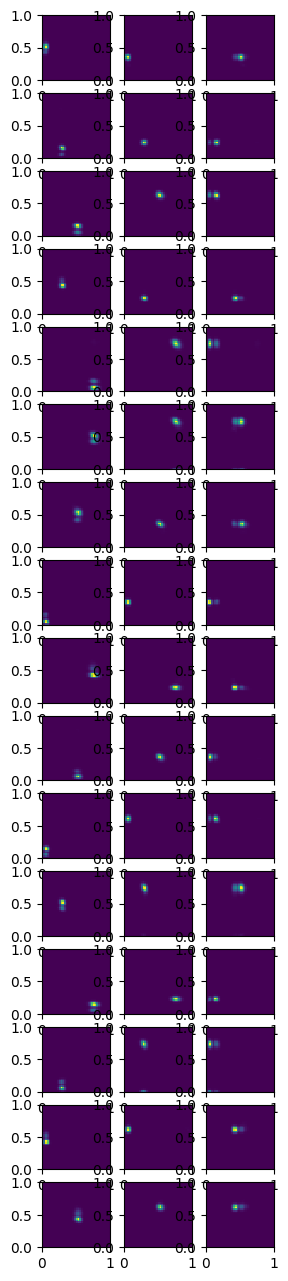

In [168]:
import itertools as it 


plt.figure(figsize=(3, 16))
for k, (l, (i, j)) in enumerate(it.product(range(16), it.combinations(range(3), 2)), start=1):
    plt.subplot(16, 3, k)
    plt.hist2d(p[..., l, i], p[..., l, j], bins=40, range=((0, 1), (0, 1)))

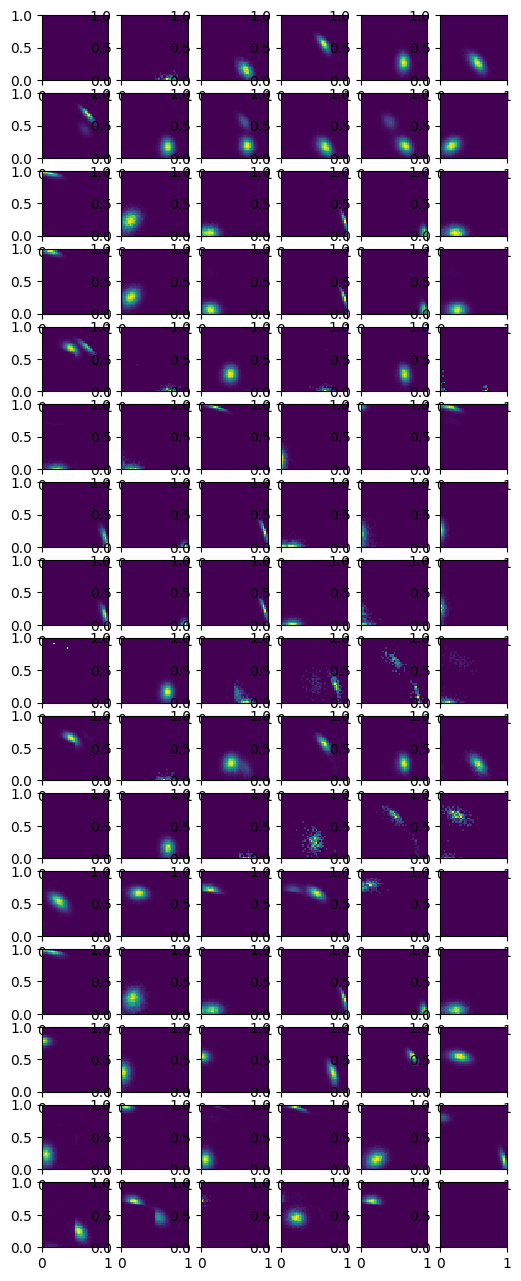

In [169]:
import itertools as it 


plt.figure(figsize=(6, 16))
for k, (l, (i, j)) in enumerate(it.product(range(16), it.combinations(range(4), 2)), start=1):
    plt.subplot(16, 6, k)
    plt.hist2d(q[..., l, i], q[..., l, j], bins=40, range=((0, 1), (0, 1)))

In [ ]:
import itertools as it 


plt.figure(figsize=(3, 16))
for k, (p, (i, j)) in enumerate(it.product(range(16), it.combinations(range(3), 2)), start=1):
    plt.subplot(16, 3, k)
    plt.hist2d(p_[..., p, 0, i], p_[..., p, 0, j])

In [157]:
r.shape

(3,)

In [278]:
from functools import partial

def energy(p, b):
    simulation.context.setPositions(p)
#     box_norm = scipy.stats.multivariate_normal(box_mean, box_cov)
#     b = np.eye(3) * box_norm.rvs()
    simulation.context.setPeriodicBoxVectors(b[0], b[1], b[2])
    state = simulation.context.getState(getEnergy=True, getForces=True)
    energy = state.getPotentialEnergy().value_in_unit(unit.kilojoule_per_mole)
    force = state.getForces(asNumpy=True).value_in_unit(unit.kilojoule_per_mole / unit.nanometer)
    return np.array(energy, np.float32), force.astype(np.float32)


def energy_and_forces(p, b):
    shape_specs = (
        jax.ShapedArray((), jnp.float32),
        jax.ShapedArray(p.shape, jnp.float32)
    )
    return jax.pure_callback(
        energy, shape_specs, p, b
    )

In [284]:
pos_ = jnp.tile(pos[None], (100, 1, 1))
box_ = jnp.tile((box * jnp.eye(3))[None], (100, 1, 1))

In [285]:
%%timeit 
for p, b in zip(pos_, box_):
    energy(pos, box * np.eye(3))

28.2 ms ± 3.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [287]:
%%timeit 
jax.jit(jax.vmap(energy_and_forces))(pos_, box_)

118 ms ± 5.66 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [35]:
energy_and_forces(pos, box)

(DeviceArray(-795.54675, dtype=float32),
 DeviceArray([[-5.82345398e+02, -3.22835400e+03, -2.57644727e+03],
              [ 7.82603821e+02, -1.67749588e+02,  4.83937714e+02],
              [-1.97130222e+01,  1.38423596e+03,  8.95118286e+02],
              [-9.76645020e+02, -1.15505933e+03, -1.22578894e+03],
              [-1.25539160e+03, -1.00142572e+03, -4.78438232e+02],
              [ 3.05881378e+02,  1.00988910e+03,  1.07713921e+02],
              [ 9.35515503e+02, -7.71954269e+01,  2.85892975e+02],
              [-1.66237793e+03, -1.16154089e+03, -6.26015930e+02],
              [-2.05958252e+03,  2.23778687e+02,  1.33126489e+03],
              [ 5.10429382e+02,  2.23470291e+02, -9.61715210e+02],
              [ 1.07758313e+03,  7.37406372e+02, -5.01718941e+01],
              [-1.10609998e+03, -1.59921069e+03,  9.40104370e+02],
              [-1.14667444e+03, -5.88761353e+02, -1.20450684e+03],
              [ 8.92087524e+02,  4.27576233e+02,  1.37495071e+02],
              [ 1.148

In [ ]:
%timeit energy_and_forces(p, b)[0].block_until_ready()